In [1]:
import torch
import pandas as pd
import random
from epifit.network_generation import generate_random_network
from epifit.graphing_utils import *
from matplotlib import pyplot as plt
#from epifit.transitions import S_I

device = "cuda" if torch.cuda.is_available() else "cpu"

def Population(n:int, device= "cpu"):
  initial_population = { #a columnar DB somewhat reminds the Pandas DataFrame 
      "I":torch.zeros(n).to(device),
      "susceptiveness":torch.ones(n).to(device).requires_grad_(True)*1.0,
      "infectiveness":torch.ones(n).to(device).requires_grad_(True)*1.0
  }
  initial_population["I"][0]=1 #first one infective
  return initial_population

def print_model_parameters(model):
    for name, parameter in model.named_parameters():
        print('name           : {}'.format(name))
        print('parameter      : {}'.format(parameter.item()))
        print('learnable      : {}'.format(parameter.requires_grad))
        print('parameter.shape: {}'.format(parameter.shape))
        print('parameter.grad: {}'.format(parameter.grad))
        print('---------------------------------')

class SI_dense(torch.nn.Module):
    """
    Stochastic individual base (S)usceptible-(I)nfective transition. 
    The infective agent propagates through an unweighted contact network 
    stored as a dense Tensor.     
    """
    def __init__(self, contact_net, pinf, I_name, susceptiveness_name, infectiveness_name, device, samples=[], start=0):
        super(SI_dense,self).__init__()
        self._contact_net = contact_net
        self._pinf = torch.nn.parameter.Parameter(torch.Tensor([pinf]).to(device)) # set it as trainnable
        self._n = contact_net.size()[0]
        self._t = 0
        self._start = start
        self._states_names = {'I': I_name, 'susceptiveness': susceptiveness_name, 'infectiveness': infectiveness_name}
        self._samples= samples
        
    def forward(self, states):
        self._t+=1
        if self._t >= self._start:
            I = states[self._states_names['I']] # boolean state of being infected
            susceptiveness = states[self._states_names['susceptiveness']] # floating point, number between 0 and 1 means probability of being infected
            infectiveness = states[self._states_names['infectiveness']] # floating point, number between 0 and 1 means probability of infecting another
    
            susceptible = (I==0).float()
            susceptible*=susceptiveness
            susceptible = susceptible.unsqueeze(dim=1)
            infective=infectiveness*I
            infective=infective*self._pinf
            infective = infective.unsqueeze(dim=0)

            con = self._contact_net*infective*susceptible#n*n, 1*n (row multiply), n*1 (column multiply)
            con = torch.log(1 - con)     
            dI = 1 - torch.exp(con.mm(torch.ones(self._n).to(device).unsqueeze(dim=1)).squeeze()) # probability of being infected that day
            #print(dI)
            dIsample= self.get_random_from_samples()
            #random will effect the result, less than operation will lose gradient
            dI_01= dI>dIsample

            dI= dI*(1-I)
            

            I = torch.max(I, dI_01) # got infected

            states[self._states_names['I']] = I

        return states, dI
    def get_random_from_samples(self):
        if self._samples==[]:
            return torch.rand(self._n).to(device)
        return self._samples[self._t-1]

In [2]:
def sim(time_horizon, population, model, mode="run"):
  log = [population['I']]
  IMeans = [torch.tensor(0).to(device)]
  for i in range(time_horizon):
    population, dI = model(population)
    log.append(population['I'])
    IMeans.append(dI.sum()+IMeans[-1])
  log = torch.stack(log)
  IMeans = torch.stack(IMeans)
  log = log.unsqueeze(dim=1)
  log = log.unsqueeze(dim=0)
  return log, IMeans

In [17]:
n= 1000
avgDegree = 10  #every individual will have 10 contacts on average
pinf = 0.2  #it is the first parameter we are going to fit
time_horizon = 20
#create  dense contacts
contacts = generate_random_network(n, avgDegree)
contacts = contacts.coalesce()#make pairs unique
contacts = contacts.to_dense()
contacts = contacts.requires_grad_(True)
#random to be used
dIsamples=[]
for _ in range(time_horizon):
    dIsamples.append(torch.rand(n).to(device))
#si true 
si =     SI_dense(contacts, pinf=pinf, I_name="I",susceptiveness_name="susceptiveness",  infectiveness_name="infectiveness", 
                samples=dIsamples, device=device)
#si fit deterministic
si_fit = SI_dense(contacts, pinf=0.05, I_name="I", susceptiveness_name="susceptiveness",  infectiveness_name="infectiveness", 
                samples=dIsamples, device=device)
#si fit random
si_fit_random = SI_dense(contacts, pinf=0.05, I_name="I", susceptiveness_name="susceptiveness",  infectiveness_name="infectiveness", 
                samples=[], device=device)
#generate real data
si_result= None
with torch.no_grad():
    population = Population(n, device=device)
    si_result, _ = sim(time_horizon, population, si, mode="run")



0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

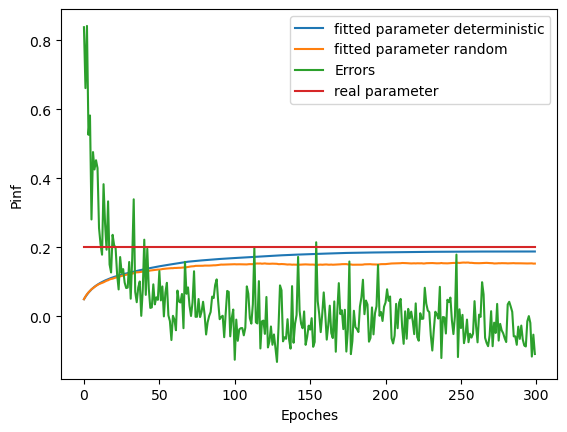

In [18]:
fitPinfs=[]
fitRandomPinfs=[]
#deinfe loss function
loss_fn = torch.nn.MSELoss(reduction='sum')
optimizer = torch.optim.SGD(si_fit.parameters(), lr=1e-10)
optimizer2 = torch.optim.SGD(si_fit_random.parameters(), lr=1e-10)

stats_gt   = si_result.sum(dim=3) # si along 20 iterations
stats_gt   = stats_gt.squeeze()
stats_gt.requires_grad_(True)
colors = [("red", 'I')]
age_sizes = [n]
for i in range(300):
    print(i)
    fitPinfs.append(si_fit._pinf.item())
    si_fit._t=0
    population = Population(n, device=device)
    si_pred, IMeans_pred = sim(time_horizon, population, si_fit, mode="train")
    loss = loss_fn(stats_gt, IMeans_pred)
    loss.backward(retain_graph=True)
    optimizer.step()
    optimizer.zero_grad()
torch.cuda.empty_cache()

colors = [("red", 'I')]
age_sizes = [n]
errors=[]
for i in range(300):
    print(i)
    fitRandomPinfs.append(si_fit_random._pinf.item())
    si_fit_random._t=0
    population = Population(n, device=device)
    si_pred_random, IMeans_pred = sim(time_horizon, population, si_fit_random, mode="train")
    si_pred_random= si_pred_random.sum(dim=3) 
    si_pred_random= si_pred_random.squeeze()
    error= (stats_gt-si_pred_random).sum()
    errors.append(error.item()/10000)
    loss = loss_fn(stats_gt, IMeans_pred)
    loss.backward(retain_graph=True)
    optimizer2.step()
    optimizer2.zero_grad()

plt.plot(fitPinfs, label='fitted parameter deterministic')
plt.plot(fitRandomPinfs, label='fitted parameter random')
#plt.plot(errors, label='Errors')
plt.plot([pinf]*len(fitPinfs), label='real parameter')
plt.xlabel("Epoches")
plt.ylabel("Pinf")
plt.legend()


Parameter containing:
tensor([nan], device='cuda:0', requires_grad=True)
